## Quantitative Finance & Algorithmic Trading 

### Markowitz-Portfolio Theory

Assumptions 
- historical data is the best estimator for future performance 
- returns are normally distributed
- investors are risk averse

Goal: the efficient portfolio
- find the highest return given a level of risk, or
- find the lowest risk given a level of return
- risk is measured by the variance of a stock
- achieve diversification by chosing uncorrelated stocks



Efficient-frontier 
- portfoilios with the highest return for values of risk
- they are the portfolios at the top left side of the curve

Sharpe Ratio
- SR = (expected portfolio return - risk free return) / portfolio risk
- a Sharpe Ratio > 1 is considered good
- Warren Buffet's portfoilio has a SR > 3


Parameters:
- Wi - weight for the ith stock
- Ri - return for the ith asset (based on historical data)
- Hi - expected return for the ith stock (mean of the returns)

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization
import yfinance as yf

##### Retrieving Stock Data

In [37]:
# stocks we are going to handle
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

# historical data - define START and END dates
start_date = '2010-01-01'
end_date = '2017-01-01'

def download_data():
    # name of the stock (key) - stock values (2010-1017) as the values
    stock_data = pd.DataFrame()

    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']

    return stock_data

def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()

In [38]:
df = download_data()
df

,AAPL,WMT,TSLA,GE,AMZN,DB
Date,,,,,,
2010-01-04,6.535085,40.658020,NaN,87.554321,6.695000,57.798649
2010-01-05,6.546384,40.253170,NaN,88.007706,6.734500,58.903645
2010-01-06,6.442256,40.163200,NaN,87.554321,6.612500,57.885471
2010-01-07,6.430345,40.185699,NaN,92.087883,6.500000,58.540565
2010-01-08,6.473094,39.983265,NaN,94.071327,6.676000,60.655834
...,...,...,...,...,...,...
2016-12-23,27.344471,62.367863,42.667999,227.416214,38.029499,17.539484
2016-12-27,27.518137,62.511356,43.905998,227.558914,38.570000,17.294706
2016-12-28,27.400793,62.161583,43.948002,226.132187,38.606499,16.871048


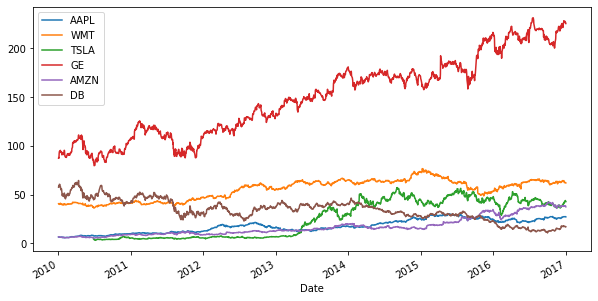

In [39]:
show_data(df)

##### Creating Random Portfolios 

In [57]:
# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252

def calculate_return(data):
    # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data / data.shift(1)) # daily log return 
    return log_return[1:] # the first row consists of NaNs


In [60]:
# we will generate random w (different portfolios)
NUM_PORTFOLIOS = 10000

# generating 10,000 random portfolios given the returns of selected stocks 
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks)) # randomly choose 10,000 portfolios
        w /= np.sum(w) # sum of w is now 1
        portfolio_weights.append(w) # randomly selected weights 
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS) # expected return for this randomly weighted portfolio
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()
                                                          * NUM_TRADING_DAYS, w)))) # expected risk for this randomly weighted portfolio

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [61]:
returns = calculate_return(df)
returns

,AAPL,WMT,TSLA,GE,AMZN,DB
Date,,,,,,
2010-01-05,0.001728,-0.010007,NaN,0.005165,0.005883,0.018938
2010-01-06,-0.016034,-0.002238,NaN,-0.005165,-0.018282,-0.017437
2010-01-07,-0.001851,0.000560,NaN,0.050484,-0.017160,0.011254
2010-01-08,0.006626,-0.005050,NaN,0.021310,0.026717,0.035496
2010-01-11,-0.008860,0.016366,NaN,0.009593,-0.024335,-0.005611
...,...,...,...,...,...,...
2016-12-23,0.001976,-0.000719,0.023188,0.001884,-0.007532,0.004843
2016-12-27,0.006331,0.002298,0.028602,0.000627,0.014113,-0.014054
2016-12-28,-0.004273,-0.005611,0.000956,-0.006289,0.000946,-0.024801


In [63]:
weights, means, risks = generate_portfolios(returns)

In [64]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

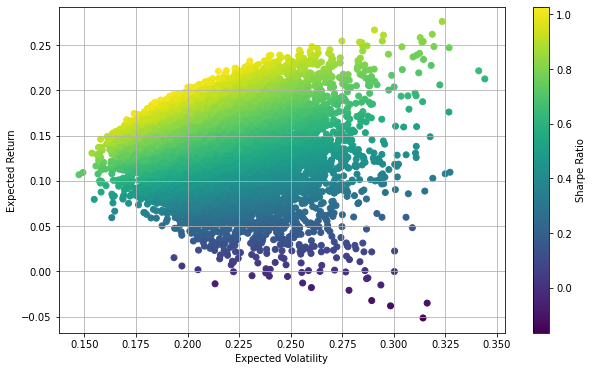

In [68]:
show_portfolios(means,risks)
# portfolio at the efficient frontier are yellow, with Sharpe Ratio > 1

##### Finding the optimal portfolio using Scipy

In [89]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()* NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2] #the third element is the Sharpe Ratio


# what are the constraints? The sum of weights = 1 !!!
# f(x)=0 this is the function to minimize
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)

def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), returns))


def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

Optimal portfolio:  [0.363 0.076 0.141 0.155 0.264 0.   ]
Expected return, volatility and Sharpe ratio:  [0.21218697 0.2055503  1.0322873 ]


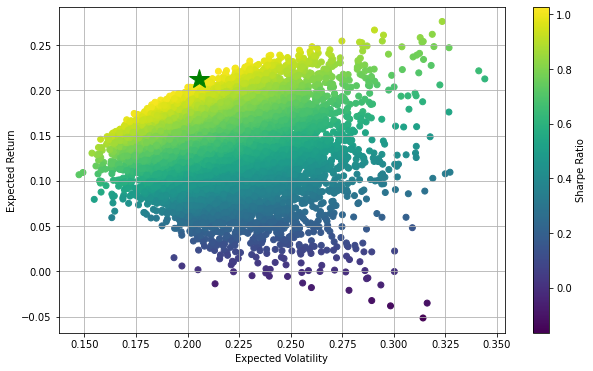

In [90]:
# Optimal portfolios
# Note: [weights, means, risks] are generated in the previous step
optimum = optimize_portfolio(weights, returns)
print_optimal_portfolio(optimum, returns)
show_optimal_portfolio(optimum, returns, means, risks)

-------------------------------------------------------------------------------------------------

--------------------------------------------------

### Capital Asset Pricing Model (CAPM)

##### Risk

Unsystematic risk
- risk pertaining to a specific stock
- can be diverzified away by holding multiple stocks in a portfolio

Systematic risk (Beta)
- risk pertaining to the entire stock market
- interest rate changes, recessions, wars
- systematic risk is the only risk in CAPM since we assume that we eliminated unsystematic risk via diversification 
- CAPM uses Beta parameter to capture this risk

##### CAPM & Beta parameter

Beta parameter = Cov(returns of our portfolio, returns of the market) / Var(returns of the market)
- we can use SP500 or NASDAQ to calculate the returns of the market
- Beta measures the stock's relative volitility to the market
- Beta is the only relevant risk in this model because we assume that we eliminated unsystematic risk via diversification 
- Beta for a portfolio = the weighted sum of beta for the stocks in the portfolio
- B = 1 : stock moving exactly with the market
- B > 1 : stock more volitile than market, thus higher expected returns
- B < 1 : stock less volitile than market, thus lower expected returns

CAPM: Expected portfolio return = risk-free return + Beta * (market excess return)
- risk-free return = treasury bills or gov bonds
- market excess return = (expected return of the market - risk-free return)
- linear relationship between expected returns and market premium (how much we can make given a risk level)

##### CAPM class

In [133]:
class CAPM:

    def __init__(self, stocks, start_date, end_date):
        self.data = None
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date

    def download_data(self):
        data = {}

        for stock in self.stocks:
            ticker = yf.download(stock, self.start_date, self.end_date)
            data[stock] = ticker['Adj Close']

        return pd.DataFrame(data)
    
    def initialize(self):
        stock_data = self.download_data()
        # we use monthly returns instead of daily returns
        stock_data = stock_data.resample('M').last()

        self.data = pd.DataFrame({'s_adjclose': stock_data[self.stocks[0]],
                                  'm_adjclose': stock_data[self.stocks[1]]})

        # logarithmic monthly returns
        self.data[['s_returns', 'm_returns']] = np.log(self.data[['s_adjclose', 'm_adjclose']] /
                                                       self.data[['s_adjclose', 'm_adjclose']].shift(1))

        # remove the NaN values
        self.data = self.data[1:]

    def calculate_beta(self):
        # covariance matrix: the diagonal items are the variances
        # off diagonals are the covariances
        # the matrix is symmetric: cov[0,1] = cov[1,0] !!!
        covariance_matrix = np.cov(self.data["s_returns"], self.data["m_returns"])
        # calculating beta according to the formula
        beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
        print("Beta from formula: ", beta)

    def regression(self):
        # using linear regression to fit a line to the data
        # [stock_returns, market_returns] - slope is the beta
        beta, alpha = np.polyfit(self.data['m_returns'], self.data['s_returns'], deg=1)
        print("Beta from regression: ", beta)
        # calculate the expected return according to the CAPM formula
        # we are after annual return (this is why multiply by 12)
        expected_return = RISK_FREE_RATE + beta * (self.data['m_returns'].mean()*MONTHS_IN_YEAR
                                                   - RISK_FREE_RATE)
        print("Expected return: ", expected_return)
        self.plot_regression(alpha, beta)

    def plot_regression(self, alpha, beta):
        fig, axis = plt.subplots(1, figsize=(20, 10))
        axis.scatter(self.data["m_returns"], self.data['s_returns'],
                     label="Data Points")
        axis.plot(self.data["m_returns"], beta * self.data["m_returns"] + alpha,
                  color='red', label="CAPM Line")
        plt.title('Capital Asset Pricing Model, finding alpha and beta')
        plt.xlabel('Market return $R_m$', fontsize=18)
        plt.ylabel('Stock return $R_a$')
        plt.text(0.08, 0.05, r'$R_a = \beta * R_m + \alpha$', fontsize=18)
        plt.legend()
        plt.grid(True)
        plt.show()

##### Modeling Berkshire Hathaway Stock Using CAPM

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Beta from formula:  0.824681352766594
Beta from regression:  0.8246813527665942
Expected return:  0.05685460913155917


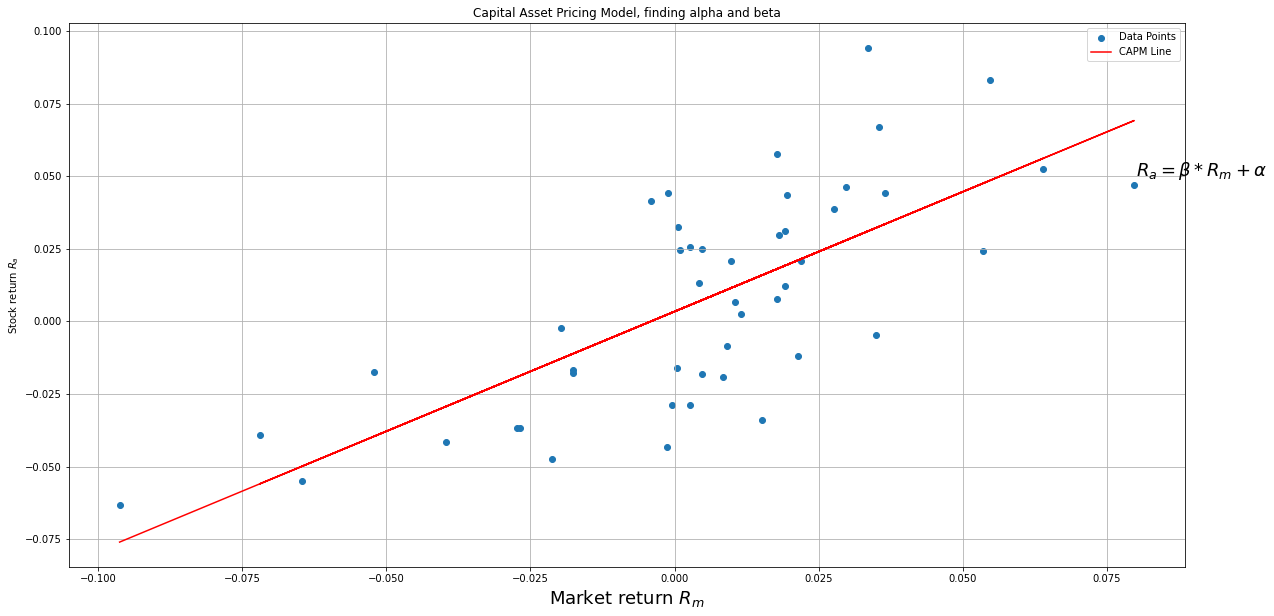

In [137]:
# market interest rate
RISK_FREE_RATE = 0.05
# we will consider monthly returns - and we want to calculate the annual return
MONTHS_IN_YEAR = 12

capm = CAPM(['BRK-A', '^GSPC'], '2015-01-01', '2019-01-01') # BRK-A: Berkshire Ticker; ^GSPC: SP500 Ticker
capm.initialize()
capm.calculate_beta()
capm.regression()